In [11]:
import warnings
import random 
import os
import pandas as pd 
import numpy as np 
import glob
import duckdb
import geopandas as gpd 
from scipy.stats import ranksums
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests

class DataLoader: 

    ZCTA_geo_datapath = '../datasets/State-zip-code-GeoJSON/*.json'
    claims_data_path='../datasets/Flood-insurance/FimaNfipClaims.csv'
    redfin_data_path='../datasets/Zillow-home-prices/zip_code_market_tracker.tsv000'
    irs_data_path='../datasets/Demographics/22irs.csv'

    FRED_api_endpoint = 'https://api.stlouisfed.org/fred/series/observations'
    FRED_api_key = '8fd9759bac0caf671d3462eed0b34d68'

    DUCKDB_location = '../datasets/combined_data2.db'
    
    def __init__(self): 
        try:
            self.con = self.initialize_ddb()
        except Exception as e: 
            print(e) 
            pass 

    def retrieve_state_data_snapshot(self, state):

        assert hasattr(self, 'con')

        subqueryclaims_re = f'''
        with realestate_data as (
        select * from redfin_dataset where STATE_CODE = '{state}'
        )
        select *
        from realestate_data 
        left join nfip_claims_zip using (zip,month,year)
        order by zip,year,month
        ;
        '''

        subquery_irs = f'''
        select * from irs_zip where STATE = '{state}'
        ;
        '''

        claims_realestate = self.con.sql(subqueryclaims_re).df()
        socioeconomic_tax_confounders = self.con.sql(subquery_irs).df() 

        num_rets_feats = [
            'numberTaxReturns',
            'elderlyReturns', 
            'returnsTotalwSalariesWages',
            'returnsDependentCareCredit', 
            'returnsEducationCredit'
        ] 
        piv=socioeconomic_tax_confounders.pivot(
            index='zip', columns='adjGrossIncomeTaxBracket', values='numberTaxReturns'
        ) 
        piv_norm = piv.div(piv.sum(axis=1),axis=0)
        grp = socioeconomic_tax_confounders.groupby('zip')[num_rets_feats].sum()
        grp = grp.div(grp['numberTaxReturns'],axis=0).drop(columns=['numberTaxReturns'])
        feature_matrix = pd.concat((piv_norm,grp),axis=1)

        all_data = feature_matrix.merge(
            claims_realestate.set_index('zip'), 
            how='inner', 
            on=['zip']
        )

        all_data = all_data\
            .reset_index()\
            .sort_values(by=['zip','year','month'])\
            .set_index(['zip','year','month'])\
            .drop(columns=['STATE_CODE','state'])\
            .fillna(0)\
            .replace('NA',0.0)\
            .astype(np.float32)
        
        all_data['risk_regime'] = all_data['totalLossesZip'] > 0

        return all_data

        
    def retrieve_macroeconomic_data(self):

        if hasattr(self, 'macro_data'):
            return self.macro_data 
            
        econ_dataset_codes = {
            'fed_funding_rate':'DFF', 
            '30yr_mortgage_avg':'MORTGAGE30US', 
            '15yr_mortgage_avg':'MORTGAGE15US',  
            'consumer_price_idx':'CPIAUCSL', 
            'real_disposable_income':'DSPIC96', 
            'real_disp_income_per_capita':'A229RX0'
        }

        data=[]
        for col, code in econ_dataset_codes.items(): 
            params = {
                'series_id': code, 'api_key': self.FRED_api_key, 'file_type': 'json'
            }
            try: 
                resp = requests.get(self.FRED_api_endpoint, params=params).json()
                resp_df = pd.DataFrame(resp['observations'])\
                    .drop(columns=['realtime_start','realtime_end'])\
                    .rename(columns={'value':col})
                resp_df[col] = resp_df[col].astype(float)
                resp_df['date'] = pd.to_datetime(resp_df['date'])
                resp_df['year'] = resp_df['date'].dt.year
                resp_df['month'] = resp_df['date'].dt.month 
                resp_df_monthly = resp_df\
                    .drop(columns=['date'])\
                    .groupby(['year','month'])[[col]].mean()
            
                data.append(resp_df_monthly)
            except Exception as e: 
                print(e)
                continue
                        
        cct = pd.concat(data,axis=1)\
            .sort_values(by=['year','month'])\
            .reset_index()
        cct['date'] = cct['year'].astype(str) + '-' + cct['month'].astype(str) 
        cct['date'] = pd.to_datetime(cct['date']) 
        cct = cct.set_index('date')
        self.macro_data = cct
        return cct
    
    def initialize_ddb(self):
        
        if os.path.exists(self.DUCKDB_location): 
            return duckdb.connect(self.DUCKDB_location)
            
        base_query = '''
        drop table if exists nfip_claims
        ;

        create table nfip_claims as 
        select  
            id,
            asOfDate, 
            dateOfLoss,
            policyCount as insuredUnits, 
            baseFloodElevation, 
            ratedFloodZone, 
            occupancyType, 
            originalConstructionDate, 
            originalNBDate, 
            coalesce(amountPaidOnBuildingClaim,0) +                  
            coalesce(amountPaidOnContentsClaim,0) +                  
            coalesce(amountPaidOnIncreasedCostOfComplianceClaim,0) as totalClaim, 
            coalesce(totalBuildingInsuranceCoverage,0) + 
            coalesce(totalContentsInsuranceCoverage,0) as totalCovered, 
            coalesce(buildingDamageAmount,0) + coalesce(contentsDamageAmount,0) as totalDamageLoss, 
            buildingDeductibleCode, 
            contentsDeductibleCode,
            causeOfDamage, 
            buildingPropertyValue, 
            floodproofedIndicator, 
            floodEvent, 
            state, 
            reportedZipCode, 
            censusTract, 
            latitude, 
            longitude
        from read_csv('{claims_data_path}', strict_mode=False)
        ;

        drop table if exists nfip_claims_zip 
        ; 

        create table nfip_claims_zip as 
        select 
            reportedZipCode as zip, 
            state,
            extract('year' from dateOfLoss) as year,
            extract('month' from dateOfLoss) as month,
            count(id) as claimCounts,
            count(floodEvent) as numEvents,
            sum(insuredUnits) as policyCounts, 
            sum(totalClaim) as totalClaimZip, 
            sum(totalDamageLoss) as totalLossesZip
        from nfip_claims
        where dateOfLoss >= '2000-01-01'
        group by 1,2,3,4
        order by 5 desc
        ;

        drop table if exists irs_zip
        ;

        create table irs_zip as 
        select 
            STATE, 
            ZIPCODE as zip, 
            AGI_STUB as adjGrossIncomeTaxBracket,
            N1 as numberTaxReturns, 
            MARS1 as singleStatusTotalReturns, 
            MARS2 as marriedStatusTotalReturns, 
            MARS4 as HoHTotalReturns, 
            N2 as totalIndividuals,
            VITA as volunteerAssistedReturns, 
            ELDERLY as elderlyReturns, 
            A00100 as adjustedGrossIncome, 
            A02650 as totalIncome, 
            N00200 as returnsTotalwSalariesWages, 
            N00300 as returnsTotalTaxableInterest, 
            A00300 as taxableInterestAmt,
            SCHF   as returnsTotalFarm, 
            A18450 as stateLocalSalesTaxTotal, 
            N18500 as realEstateTaxTotal, 
            N18800 as returnsTotalPersonalPropertyTax, 
            A18800 as propertyTaxAmtTotal, 
            N19300 as returnsTotalMortgageInterestPaid, 
            A19300 as mortgageInterestPaidTotal,
            N07225 as returnsDependentCareCredit, 
            A07225 as dependentCareCreditTotal, 
            N07230 as returnsEducationCredit, 
            A07230 as educationCreditTotal, 
            N85770 as returnsPremiumsCredit, ---aids in offsetting health insurance premiums
            A85770 as premiumsCreditTotal, 
        from read_csv('{irs_data_path}', strict_mode=False)
        ;
    
        drop table if exists redfin_dataset
        ;

        create table redfin_dataset as 
        select 
            extract('year' from PERIOD_BEGIN) as year, 
            extract('month' from PERIOD_BEGIN) as month,
            substring(REGION,11,6) as zip, 
            STATE_CODE,
            MEDIAN_SALE_PRICE, 
            MEDIAN_SALE_PRICE_MOM, 
            MEDIAN_PPSF, 
            HOMES_SOLD, 
            HOMES_SOLD_MOM, 
            PENDING_SALES, 
            PENDING_SALES_MOM, 
            NEW_LISTINGS, 
            NEW_LISTINGS_MOM, 
            INVENTORY, 
            INVENTORY_MOM, 
            SOLD_ABOVE_LIST, 
            SOLD_ABOVE_LIST_MOM, 
            OFF_MARKET_IN_TWO_WEEKS, 
            OFF_MARKET_IN_TWO_WEEKS_MOM 
        from read_csv('{redfin_data_path}', header=true, sep = '\t')
        where PROPERTY_TYPE = 'Single Family Residential' 
            and PERIOD_BEGIN >= '2015-01-01'
        '''


        con = duckdb.connect(self.DUCKDB_location)
        con.sql(
            base_query.format(
                claims_data_path=self.claims_data_path,
                redfin_data_path=self.redfin_data_path, 
                irs_data_path=self.irs_data_path, 
                zip_geos_pd=self.zip_geos_pd
            )
        )
        return con
    
dl = DataLoader()
sample = dl.retrieve_state_data_snapshot(state='LA')
sample.head(20)


1         2         3         4         5         6  \
zip   year month                                                               
70001 2015 1      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           2      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           3      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           4      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           5      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           6      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           7      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           8      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           9      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           10     0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           11     0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           12     0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
      2016 1      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           2      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           3      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           4      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           5      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           6      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           7      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   
           8      0.312609  0.235909  0.147008  0.084834  0.150494  0.069146   

                  elderlyReturns  returnsTotalwSalariesWages  \
zip   year month                                               
70001 2015 1            0.287623                    0.764091   
           2            0.287623                    0.764091   
           3            0.287623                    0.764091   
           4            0.287623                    0.764091   
           5            0.287623                    0.764091   
           6            0.287623                    0.764091   
           7            0.287623                    0.764091   
           8            0.287623                    0.764091   
           9            0.287623                    0.764091   
           10           0.287623                    0.764091   
           11           0.287623                    0.764091   
           12           0.287623                    0.764091   
      2016 1            0.287623                    0.764091   
           2            0.287623                    0.764091   
           3            0.287623                    0.764091   
           4            0.287623                    0.764091   
           5            0.287623                    0.764091   
           6            0.287623                    0.764091   
           7            0.287623                    0.764091   
           8            0.287623                    0.764091   

                  returnsDependentCareCredit  returnsEducationCredit  ...  \
zip   year month                                                      ...   
70001 2015 1                        0.201046                0.045322  ...   
           2                        0.201046                0.045322  ...   
           3                        0.201046                0.045322  ...   
           4                        0.201046                0.045322  ...   
           5                        0.201046                0.045322  ...   
           6                        0.201046                0.045322  ...   
           7                        0.201046                0.045322  ...   
           8                        0.201046                0.045322  ...   
           9                        0.201046                0.045322  ...   
        

In [13]:
dl.con.close()

#### Doubly Robust Estimation

Average Treatment Effect, Flooding effects on house prices LA: 0.003835657611489296


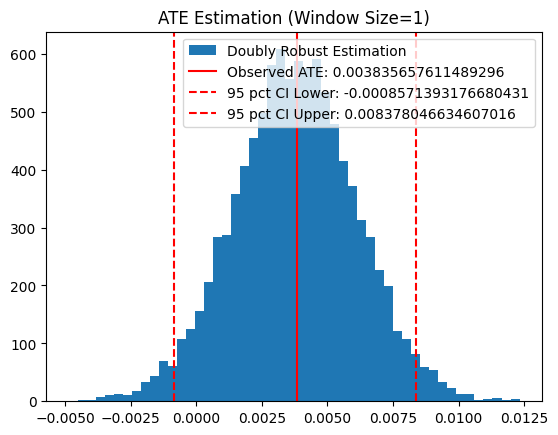

Average Treatment Effect, Flooding effects on house prices LA: -0.0015544249908998609


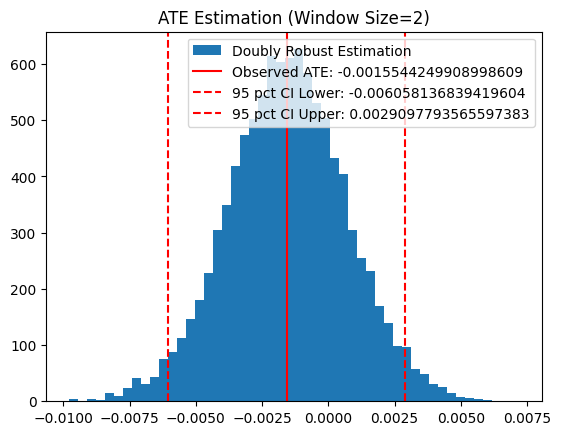

Average Treatment Effect, Flooding effects on house prices LA: -0.0016084256349131465


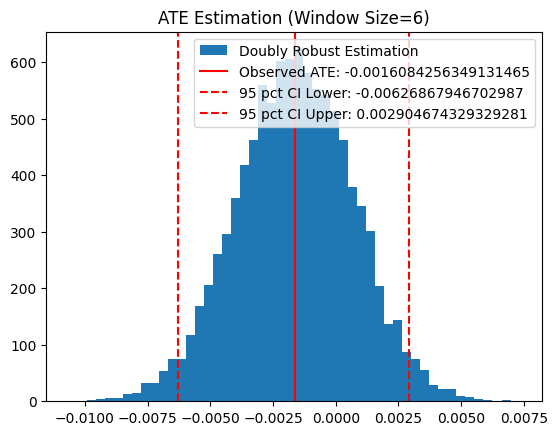

Average Treatment Effect, Flooding effects on house prices TX: -0.0028215781785547733


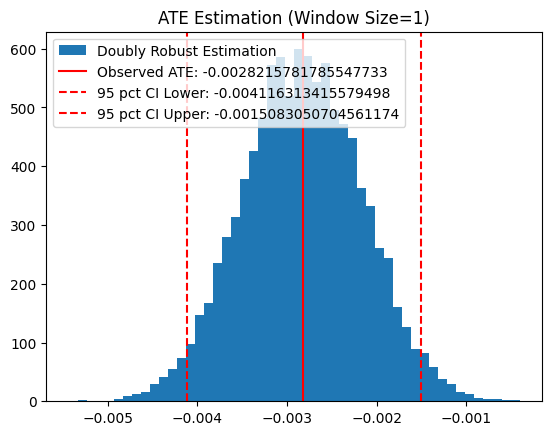

Average Treatment Effect, Flooding effects on house prices TX: -0.004452056717127562


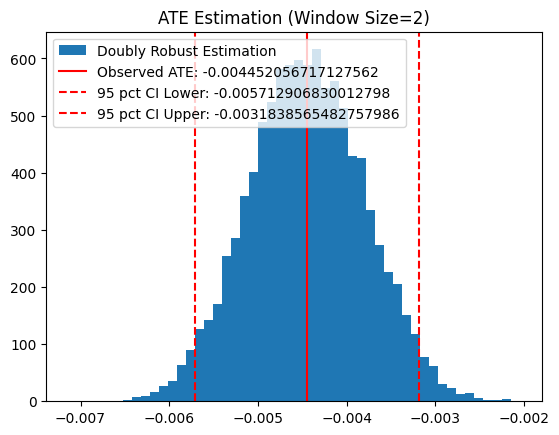

Average Treatment Effect, Flooding effects on house prices TX: -0.0033612046390771866


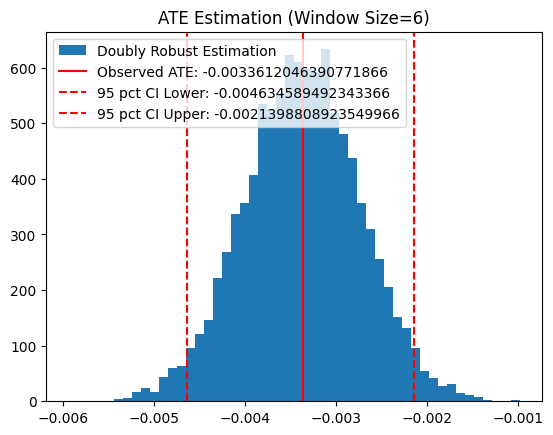

Average Treatment Effect, Flooding effects on house prices FL: -0.008401072584092617


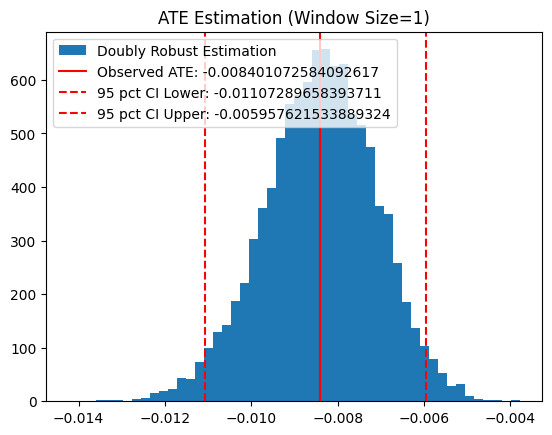

Average Treatment Effect, Flooding effects on house prices FL: -0.008402125909924507


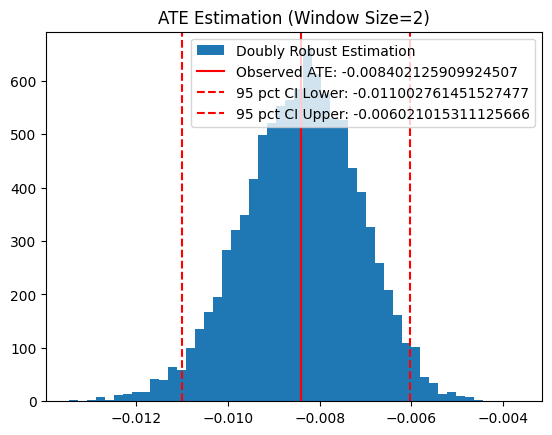

Average Treatment Effect, Flooding effects on house prices FL: -0.0071775480173528194


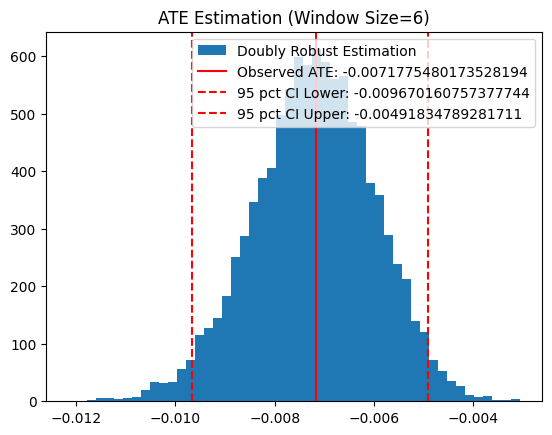

Average Treatment Effect, Flooding effects on house prices AL: -0.006506695877760649


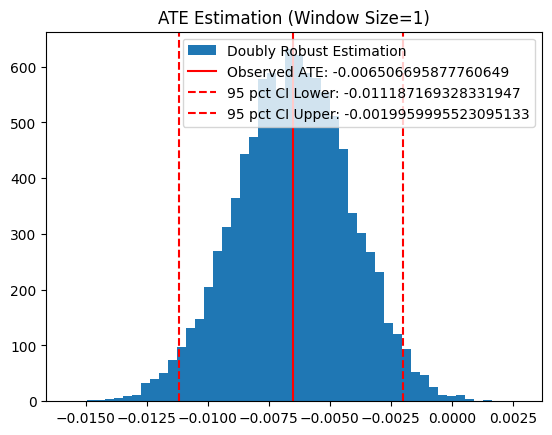

Average Treatment Effect, Flooding effects on house prices AL: 0.0007162053370848298


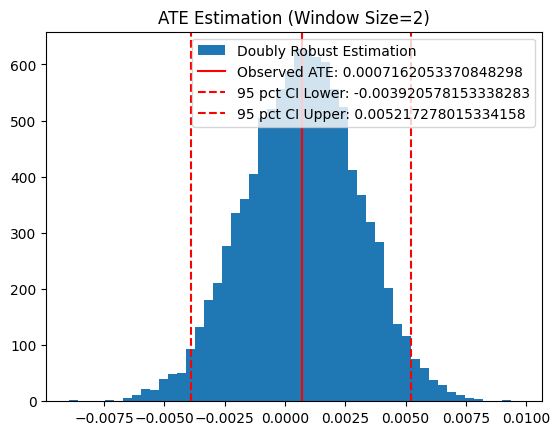

Average Treatment Effect, Flooding effects on house prices AL: 0.0010958564234897494


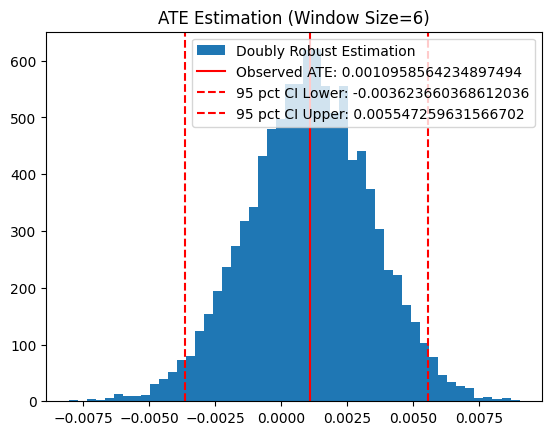

Average Treatment Effect, Flooding effects on house prices NC: -0.0031448223162442446


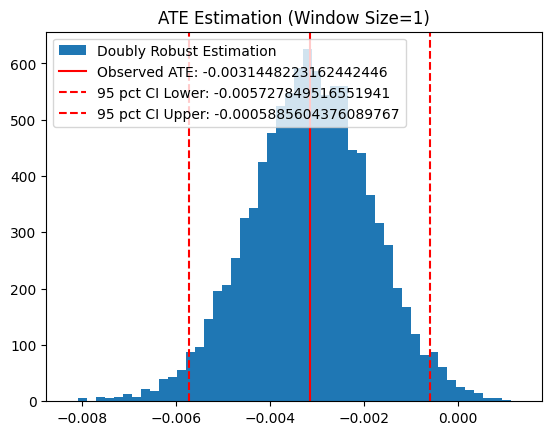

Average Treatment Effect, Flooding effects on house prices NC: -0.008543712086975574


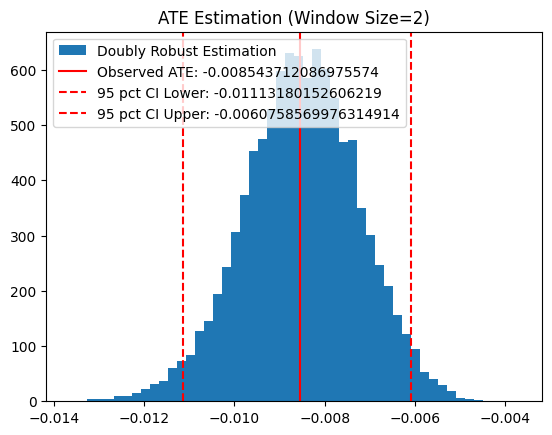

Average Treatment Effect, Flooding effects on house prices NC: -0.004135190509259701


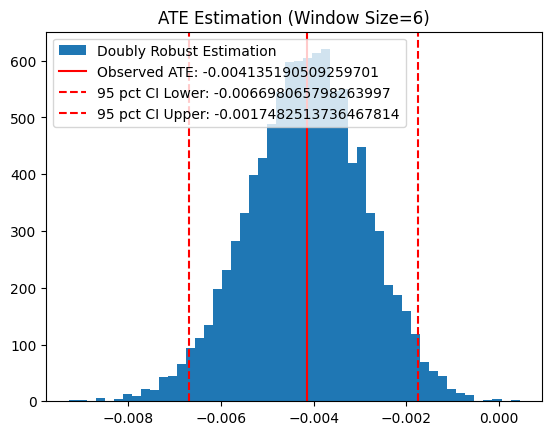

Average Treatment Effect, Flooding effects on house prices GA: -0.002811287995427847


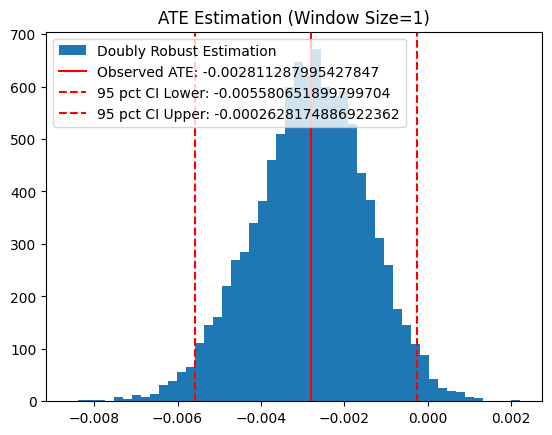

Average Treatment Effect, Flooding effects on house prices GA: -0.0054868729785084724


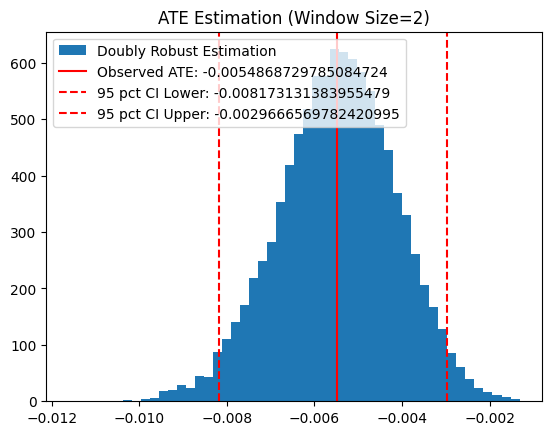

Average Treatment Effect, Flooding effects on house prices GA: -0.00038295768899843097


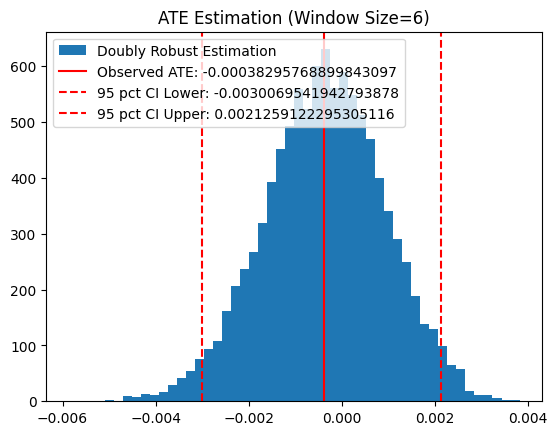

Average Treatment Effect, Flooding effects on house prices SC: -0.009525282308459282


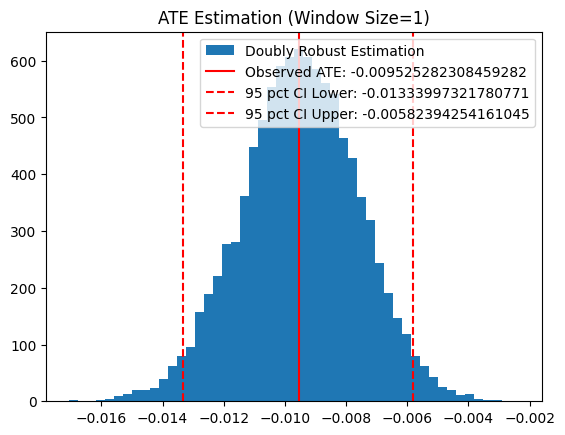

Average Treatment Effect, Flooding effects on house prices SC: -0.00803900696337223


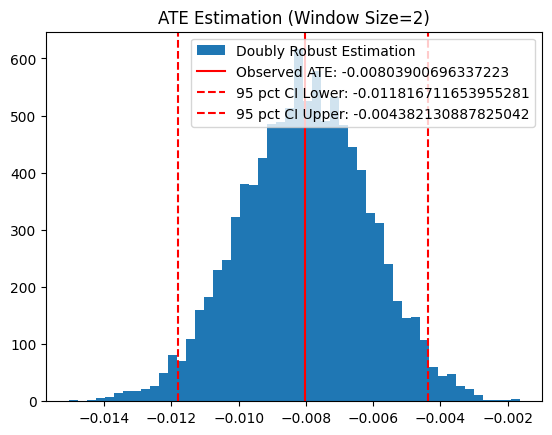

Average Treatment Effect, Flooding effects on house prices SC: -0.005979942157864571


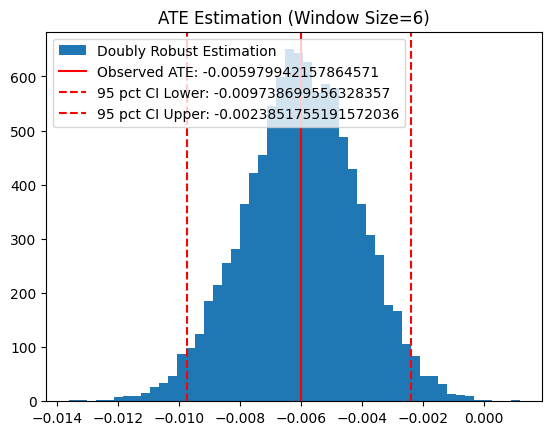

In [9]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

#fill me in below...
class DBL: 
    def __init__(self, state, window_size=1):
        dl = DataLoader()
        self.state = state
        self.dataset = dl.retrieve_state_data_snapshot(state=state)
        self.dataset = self.dataset.replace('NA',0.0).astype(np.float32)
        self.dataset['risk_regime'] = self.dataset['totalLossesZip'] > 10000
        self.dataset = self.dataset.loc[self.dataset['INVENTORY']>20]
        self.risk_window = window_size
        
        if self.risk_window > 1:
            mask = pd.concat([self.dataset.reset_index().groupby(['zip'])['risk_regime'].shift(i).bfill() for i in range(self.risk_window)], axis=1)
            mask.index = self.dataset.index
            self.dataset['risk_regime'] = mask.any(axis=1)          
            
        irs_tax_return_feats = list(self.dataset.columns[:10])
        housing_market_feats = [
            'HOMES_SOLD',
            'PENDING_SALES',
            'NEW_LISTINGS',
            'INVENTORY',
            'SOLD_ABOVE_LIST',
            'OFF_MARKET_IN_TWO_WEEKS'
        ]

        self.ttl_feats = irs_tax_return_feats + housing_market_feats
        self.causal_intervention_variable = 'risk_regime'
        self.outcome_variable = 'MEDIAN_SALE_PRICE_MOM'

    def generate_propensity_score(self, class_weight=0.5):
        X = self.dataset[self.ttl_feats].values
        T = self.dataset[self.causal_intervention_variable].astype(bool)
        lr = LogisticRegression(
            class_weight={True:class_weight,False:1-class_weight}, 
            max_iter=1000
        ) 
        lr.fit(X,T)

        self.dataset['propensity_score'] = lr.predict_proba(X)[:,1]

    def generate_enhanced_propensity_score(self, scale_factor): 
        X = self.dataset[self.ttl_feats].values
        T = self.dataset[self.causal_intervention_variable].astype(bool)
        lr = LinearRegression()
        lr.fit(X,T)

        p = lr.predict(X)
        ps = 1 - (np.exp(scale_factor + p))/(1 + np.exp(p))

        self.dataset['propensity_score'] = ps
        
    def isolate_causal_effect(self):

        #run the outcome model... 

        self.generate_enhanced_propensity_score(scale_factor=0.01)

        X = self.dataset[self.ttl_feats].values

        ttl_dataset_0 = self.dataset.loc[self.dataset[self.causal_intervention_variable]==False].drop(columns=[self.causal_intervention_variable])
        X_0, y_0 = ttl_dataset_0[self.ttl_feats].values, ttl_dataset_0[self.outcome_variable]
        y_0m = LinearRegression() 
        y_0m.fit(X_0, y_0)
        y_0h = y_0m.predict(X)


        ttl_dataset_1 = self.dataset.loc[self.dataset[self.causal_intervention_variable]==True].drop(columns=[self.causal_intervention_variable])
        X_1, y_1 = ttl_dataset_1[self.ttl_feats].values, ttl_dataset_1[self.outcome_variable]
        y_1m =  LinearRegression() 
        y_1m.fit(X_1, y_1)
        y_1h = y_1m.predict(X)

        self.dataset['y_0'] = y_0h 
        self.dataset['y_0_corrected'] = self.dataset['y_0'] + ((self.dataset[self.outcome_variable]-y_0h)/(1-self.dataset['propensity_score']))*(self.dataset[self.causal_intervention_variable].astype(np.int32)==0)
        self.dataset['y_1'] = y_1h 
        self.dataset['y_1_corrected'] = self.dataset['y_1'] + ((self.dataset[self.outcome_variable]-y_1h)/(self.dataset['propensity_score']))*(self.dataset[self.causal_intervention_variable].astype(np.int32)==1)
        self.dataset['treatment_effect'] = self.dataset['y_1_corrected']-self.dataset['y_0_corrected']
        self.dataset['treatment_effect_no_corr'] = self.dataset['y_1']-self.dataset['y_0']
       
        diffs_dbl = self.dataset['treatment_effect']
        diffs_reg_only = self.dataset['treatment_effect_no_corr']
        bootstrapped_sample_dist_dbl = pd.Series([diffs_dbl.sample(n=len(diffs_dbl), replace=True).mean() for _ in np.arange(10000)])
       
        obs = diffs_dbl.mean()
        obs_reg_only = diffs_reg_only.mean()
        print(f"Average Treatment Effect, Flooding effects on house prices {self.state}: {obs}")
        CI = [
            bootstrapped_sample_dist_dbl.quantile(0.025), 
            bootstrapped_sample_dist_dbl.quantile(0.975)
        ]

        self.report = {
            'State': self.state, 
            'Recovery Window': self.risk_window,
            'ATE Estimate': obs, 
            'ATE Confidence Bounds (95 pct)': CI, 
            'P-value': np.count_nonzero(bootstrapped_sample_dist_dbl > 0)/len(bootstrapped_sample_dist_dbl),
            'Significant?': (np.count_nonzero(bootstrapped_sample_dist_dbl > 0)/len(bootstrapped_sample_dist_dbl)) < 0.06
        }


        plt.hist(bootstrapped_sample_dist_dbl, bins=50, label='Doubly Robust Estimation')
      
        plt.title(f'ATE Estimation (Window Size={self.risk_window})')

        plt.axvline(obs, label=f"Observed ATE: {obs}",color='red')
        #plt.axvline(obs_reg_only, label=f"Observed ATE [No DRL Estimation]: {obs_reg_only}",color='orange')
        plt.axvline(CI[0], label=f"95 pct CI Lower: {CI[0]}",color='red',linestyle='--')
        plt.axvline(CI[1], label=f"95 pct CI Upper: {CI[1]}",color='red',linestyle='--')
        plt.legend()
        plt.show()

        return self.dataset, self.report


states = ['LA','TX','FL','AL','NC','GA','SC']
windows = [1,2,6]

reports=[]
for state in states:
    for window in windows:
        dbl = DBL(state=state, window_size=window)
        _, re = dbl.isolate_causal_effect()
        reports.append(re)


In [10]:
dt = pd.DataFrame(reports)
dt['ATE Upper Bound'] = dt['ATE Confidence Bounds (95 pct)'].apply(lambda x:x[1])
dt['ATE Lower Bound'] = dt['ATE Confidence Bounds (95 pct)'].apply(lambda x:x[0])
dt\
    .drop(columns=['ATE Confidence Bounds (95 pct)'])\
    .sort_values(by=['Recovery Window','State'])[[
        'State', 
        'Recovery Window',
        'ATE Estimate', 
        'ATE Upper Bound', 
        'ATE Lower Bound', 
        'P-value', 
        'Significant?'
    ]]\
    .to_csv('../datasets/causal2.csv')

Average Treatment Effect, Flooding effects on house prices SC: -0.005979942157864571


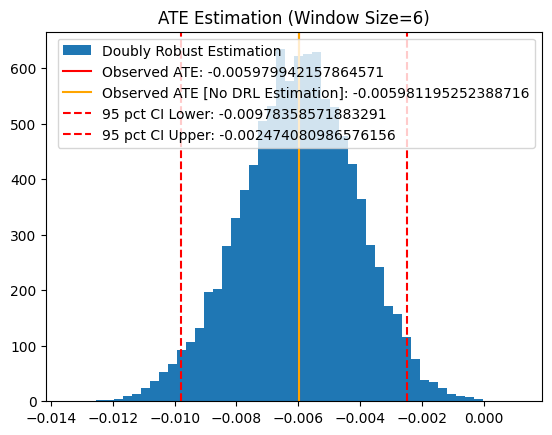

risk_regime       y_0  y_0_corrected       y_1  \
zip   year month                                                   
29048 2015 2            False  0.025910      -0.895193  0.006322   
           3            False  0.025928      -0.613996  0.006248   
           4            False  0.026085       1.175964  0.006602   
           5            False  0.025221       1.149528  0.006450   
           6            False  0.024548      -0.430855  0.006444   
           8            False  0.024471      -0.335834  0.006456   
           9            False  0.024610       1.245976  0.006279   
           10            True  0.025036       0.025036  0.006231   
           11            True  0.024606       0.024606  0.006085   
           12            True  0.024559       0.024559  0.006097   

                  y_1_corrected  treatment_effect  treatment_effect_no_corr  
zip   year month                                                             
29048 2015 2           0.006322          0.901515                 -0.019588  
           3           0.006248          0.620245                 -0.019680  
           4           0.006602         -1.169362                 -0.019483  
           5           0.006450         -1.143078                 -0.018771  
           6           0.006444          0.437299                 -0.018104  
           8           0.006456          0.342290                 -0.018015  
           9           0.006279         -1.239697                 -0.018330  
           10          0.044194          0.019158                 -0.018805  
           11          1.061666          1.037059                 -0.018522  
           12         -0.715230         -0.739789                 -0.018463

In [4]:
t=  dbl.isolate_causal_effect()
t.head(10)[['risk_regime','y_0','y_0_corrected','y_1','y_1_corrected','treatment_effect','treatment_effect_no_corr']]